In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

E = 2.1E9 # Module d'Young (en Pa)
h = 0.15 # hauteur (en m)
b = 0.15 # base (en m)
A = 0.15 * 0.15 # Section (en m2)
I = b * h ** 3 / 12 # Inertie (en m4)

nodes = []
bars = []

cas = 1
if cas == 3 :
    p = 6
    h = 2.5
    nodes = [[0,0], #0
             [p/2,0], #1
             [p,0], #2
             [p/2,h]] #3
    bars = [[0,1],
            [1,2],
            [2,3],
            [3,1],
            [3,0]]
    
    nodes = np.array(nodes).astype(float)
    bars = np.array(bars)
    
    #Apply force
    P = np.zeros_like(nodes)
    P[3,0] = 10
    P[3,1] = 10

    # support displacement
    Ur = [0, 0, 0, 0]

    DOFCON = np.ones_like(nodes).astype(int)
    DOFCON[0,:] = 0
    DOFCON[2,:] = 0
    
if cas == 1:
    a = 1
    ### Nodes
    nodes.append([0,0])
    nodes.append([a,0])
    nodes.append([a/2,np.sqrt(3)/2*a])
    ### Bars
    bars.append([0,1])
    bars.append([1,2])
    bars.append([2,0])

    nodes = np.array(nodes).astype(float)
    bars = np.array(bars)

    #Apply force
    P = np.zeros_like(nodes)
    P[2,0] = 10
    P[2,1] = 10

    # support displacement
    Ur = [0,0, 0, 0]

    DOFCON = np.ones_like(nodes).astype(int)
    DOFCON[0,:] = 0
    DOFCON[1,:] = 0
  

In [11]:
  
def rotate(x,y,xo,yo,c,s): #rotate x,y around xo,yo
    xr=c*(x-xo)-s*(y-yo)  + xo
    yr=s*(x-xo)+c*(y-yo)  + yo
    return xr,yr

In [30]:
class Frame_2D :
    def __init__(self, E, I, nodes, bars):
        self.E = E
        self.I = I
        self.nodes = nodes.astype(float)
        self.bars = bars.astype(int)
        
        self.dof = 3 # 2 translation et 1 rotation
        # Loads
        self.point_load = np.zeros([len(nodes),3]) # Fx, Fy et Mz
        self.distributed_load = np.zeros([len(bars),2])
        #BCs
        self.support = np.ones([len(nodes),3]).astype(int) # Ux, Uy et Rz
        # Geom
        self.section = np.ones(len(bars))

        self.force = np.zeros([len(bars),2 * self.dof])
        self.displacement = np.zeros([len(bars),2 * self.dof])
        
    def K_elem(self, L_e, S):
        K_elem = self.E / L_e * np.array([[S, 0, 0, -S, 0, 0],
                                          [0, 12 * self.I / L_e ** 2, 6 * self.I / L_e, 0, -12 * self.I / L_e ** 2, 6 * self.I / L_e],
                                          [0, 6 * self.I / L_e, 4 * self.I, 0, -6 * self.I / L_e, 2 * self.I],
                                          [-S, 0, 0, S, 0, 0],
                                          [0, -12 * self.I / L_e ** 2, -6 * self.I / L_e, 0, 12 * self.I / L_e ** 2, -6 * self.I / L_e],
                                          [0, 6 * self.I / L_e, 2 * I, 0, -6 * self.I / L_e, 4 * self.I]])
        return K_elem
    
    def Rot(self, c, s):
        """ Rotation matrix in 2D
        """
        Rotation_matrix = np.array([[c, -s, 0, 0, 0, 0],
                                    [s, c, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, c, -s, 0],
                                    [0, 0, 0, s, c, 0],
                                    [0, 0, 0, 0, 0, 1]])
        return Rotation_matrix
    
    def plot_matrix(self, matrix):
        fig, ax = plt.subplots()
        ax.matshow(matrix, cmap = plt.cm.Blues)
        
        for i in range(len(matrix)):
            for j in range(len(matrix[0])):
                c = matrix[i,j]
                ax.text(i,j,str(c), va = 'center', ha = 'center')
        
    def analyse(self):
        nn = len(self.nodes)
        ne = len(self.bars)
        n_dof = self.dof * nn
        
        d = self.nodes[self.bars[:, 1], :] - self.nodes[self.bars[:, 0], :]
        L = np.sqrt((d ** 2).sum(axis=1))
        angle = d.T/L
        C, S = angle[0], angle[1]
        
        #Structural matrix
        k = np.zeros([ne, 2 * self.dof, 2 * self.dof])
        ss = np.zeros([n_dof,n_dof])

        for i in range(ne) :
            aux = self.dof * self.bars[i,:]
            index = np.r_[aux[0]:aux[0] + self.dof, aux[1]:aux[1] + self.dof]

            # Element stiffness matrix
            l = L[i]
            sect = self.section[i]
            c, s = C[i], S[i]
            r =  self.Rot(c, s)
            k[i] =  r.T @ self.K_elem(l,sect) @ r

            # Global stiffness matrix
            ss[np.ix_(index,index)] += k[i]
        
        # Distributed load
        eq_load_ele = np.zeros([len(self.bars), 2 * self.dof])
        for i in range(ne):
            l = L[i]
            pi = self.distributed_load[i,0] # Fy_i
            pf = self.distributed_load[i,1] # Ry_j
            eq_load_ele[i,0] = l * (21 * pi + 9 * pf) / 60 #Fy_i
            eq_load_ele[i,1] = l * (l * (2 * pi + 3 * pf)) / 60 #Rz_i
            eq_load_ele[i,2] = l * (9 * pi + 21 * pf) / 60 #Fy_j
            eq_load_ele[i,3] = l * (l * ( - 2 * pi - 3 * pf)) / 60 #Rz_j

        # Point load
        for i in range(ne):
            self.point_load[self.bars[i, 0], 1] += eq_load_ele[i,0] #Fy_i
            self.point_load[self.bars[i, 0], 2] += eq_load_ele[i,1] #Rz_i
            self.point_load[self.bars[i, 1], 1] += eq_load_ele[i,2] #Fy_j
            self.point_load[self.bars[i, 1], 2] += eq_load_ele[i,3] #Rz_j

        #print("distance : \n",d,"\n Longeuur \n",L,"\n angle \n",a,"\n Raideur matrice \n",K,"\n")

        free_dof = self.support.flatten().nonzero()[0]
        kff = ss[np.ix_(free_dof,free_dof)]
        p = self.point_load.flatten()
        pf = p[free_dof]
        uf = np.linalg.solve(kff,pf)
        u = self.support.astype(float).flatten()
        u[free_dof] = uf
        u = u.reshape(nn,self.dof)
        u_ele = np.concatenate((u[self.bars[:,0]],u[self.bars[:,1]]),axis=1)
        f_ele = np.concatenate((self.point_load[self.bars[:,0]],self.point_load[self.bars[:,1]]),axis=1)
        for i in range(ne):
            self.force[i] = k[i] @ u_ele[i] - f_ele[i]
            self.displacement[i] = u_ele[i]
            
    def plot(self, scale = None):
        ne = len(self.bars)
        fig, axs = plt.subplots(4)
        
        # Displacement
        for i in range(ne):
            xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
            axs[0].plot([xi,xj], [yi, yj], 'k', linestyle = '--', linewidth = 1)
            self.plot_local_axis(axs[0],i)
        for i in range(ne):
            dxi, dxj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            dyi = self.nodes[self.bars[i,0],1] + self.displacement[i, 1] * scale
            dyj = self.nodes[self.bars[i,1],1] + self.displacement[i, 4] * scale
            axs[0].plot([dxi,dxj], [dyi, dyj], 'r', linewidth = 1)
            axs[0].text(dxi,dyi, str(round(dyi / scale, 4)),rotation = 45)
        axs[0].set_title('Displacement')

        # Bending moment 
        #axs[1].invert_yaxis()
        for i in range(ne):
            xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
            axs[1].plot([xi,xj], [yi, yj], 'k', linestyle = '--', linewidth = 1)
        for i in range(ne):
            xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
            mr_xi, mr_xf = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            mr_yi = - self.force[i, 2]
            mr_yf = self.force[i, 5]
            ### added by NGO
            vec_x = [(xj - xi), (yj - yi)]
            vec_y = rotate(*vec_x, 0, 0, 0, 1)
            mr_xi, mr_yi = xi + vec_y[0], yi + vec_y[1]
            mr_xf, mr_yf = xj + vec_y[0], yj + vec_y[1]
            ### end
            axs[1].plot([xi, mr_xi, mr_xf, xj], [yi, mr_yi, mr_yf, yj], 'r', linewidth = 2)
            axs[1].fill([xi, mr_xi, mr_xf, xj], [yi, mr_yi, mr_yf, yj], 'c', alpha = 0.3)
            axs[1].text(mr_xi,mr_yi, str(round(mr_yi, 4)),rotation = 45)
        axs[1].set_title('Bending Moment')
        
        # Shear Force
        for i in range(ne):
            xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
            axs[2].plot([xi,xj], [yi, yj], 'k', linestyle = '--', linewidth = 1)
        for i in range(ne):
            fr_xi, fr_xf = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            fr_yi = - self.force[i, 1]
            fr_yf = self.force[i, 4]
            axs[2].plot([fr_xi, fr_xi, fr_xf, fr_xf], [0, fr_yi, fr_yf, 0], 'r', linewidth = 2)
            axs[2].fill([fr_xi, fr_xi, fr_xf, fr_xf], [0, fr_yi, fr_yf, 0], 'y', alpha = 0.3)
            axs[2].text(fr_xi,fr_yi, str(round(fr_yi, 4)),rotation = 45)
        axs[2].set_title('Shear Force Diagram')

        # Axial Force
        for i in range(ne):
            xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
            axs[3].plot([xi,xj], [yi, yj], 'k', linestyle = '--', linewidth = 1)
        for i in range(ne):
            xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
            nr_xi, nr_xf = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
            nr_yi = - self.force[i, 0]
            nr_yf = self.force[i, 3]
            ### added by NGO
            vec_x = [(xj - xi) / 10, (yj - yi) / 10]
            vec_y = rotate(*vec_x, 0, 0, 0, 1)
            nr_xi, nr_yi = xi + vec_y[0], yi + vec_y[1]
            nr_xf, nr_yf = xj + vec_y[0], yj + vec_y[1]
            ### end
            axs[3].plot([xi, nr_xi, nr_xf, xj], [yi, nr_yi, nr_yf, yj], 'r', linewidth = 2)
            ### added
            if self.force[i, 3] > 0: # traction
                axs[3].fill([xi, nr_xi, nr_xf, xj], [yi, nr_yi, nr_yf, yj], 'r', alpha = 0.3)
            else : # compression
                axs[3].fill([xi, nr_xi, nr_xf, xj], [yi, nr_yi, nr_yf, yj], 'b', alpha = 0.3)
            ###
            #axs[3].fill([nr_xi, nr_xi, nr_xf, nr_xf], [0, nr_yi, nr_yf, 0], 'm', alpha = 0.3)
            axs[3].text(nr_xi,nr_yi, str(round(nr_yi, 4)),rotation = 45)
        axs[3].set_title('Axial Force Diagram')
        
        axs[0].set_aspect(1)
        axs[1].set_aspect(1)
        axs[2].set_aspect(1)
        axs[3].set_aspect(1)
        plt.tight_layout()
        
    def plot_local_axis(self,ax,i):
        xi, xj = self.nodes[self.bars[i,0],0], self.nodes[self.bars[i,1],0]
        yi, yj = self.nodes[self.bars[i,0],1], self.nodes[self.bars[i,1],1]
        
        L = np.sqrt((xj-xi) ** 2 + (yj - yi) ** 2)
        c = (xj - xi) / L
        s = (yj - yi) / L
        
        mx , my = (xi + xj) / 2, (yi + yj) / 2
        
        vec_x = [xj - xi, yj - yi]
        vec_y = rotate(*vec_x, 0, 0, 0, 1) # Rotation à 90°
        
        ax.quiver(mx, my, *vec_x, color = 'b') # x axis
        ax.quiver(mx, my, *vec_y, color = 'r') # y axis


force : 
  [[-1.15229226e-04 -2.43755602e-01 -1.82915299e-01  1.15229226e-04
   2.43755602e-01 -6.08403031e-02]
 [-1.15229226e-04 -2.43755602e-01  6.08403031e-02 -9.99884771e-01
   1.24375560e+00  6.09377063e-02]
 [-1.15229226e-04 -2.43755602e-01 -6.09377063e-02 -9.99884771e-01
   1.24375560e+00 -1.83110105e-01]]
deplacement : 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.48710600e-14
  5.73761870e-07 6.88959411e-07]
 [5.48710600e-14 5.73761870e-07 6.88959411e-07 4.97743917e-07
  2.86505423e-07 6.89509129e-07]
 [4.97743917e-07 2.86505423e-07 6.89509129e-07 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


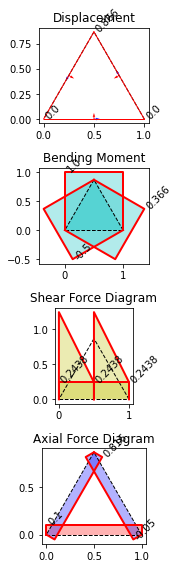

In [31]:
beam_1 = Frame_2D(E, I, nodes, bars)

point_load_1 = beam_1.point_load
point_load_1[-1,0] = 1 #Fx
point_load_1[-1,1] = -1 #Fy

distributed_load_1 = beam_1.distributed_load
#distributed_load_1[5] = np.array([-10,-20])

support_1 = beam_1.support
support_1[0, :] = 0

beam_1.analyse()
print("force : \n ", beam_1.force)
print("deplacement : \n",beam_1.displacement)
beam_1.plot(scale = 1)